**Introducción**: El siguiente trabajo contiene un dataset que recopila transacciones realizadas con tarjetas de crédito en septiembre de 2013 por titulares de tarjetas europeos; el objetivo de este trabajo es poder obtener un clasificador que nos ayude a identificar cuando una transacción es fraudulenta y cuando no (1=fraude, 0=no), Para lograr esto vamos a seleccionar algunos clasificadores vistos en clase y asociarles algunas medidas para comparar su desempeño; el clasificador a escoger sera aquel que se comporte mejor en cada una de las medidas asociadas a el y su tiempo computacional de entrenamiento sea menor con respecto a los otros.
    

In [71]:
#Librerias usadas en el trabajo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
import sklearn.linear_model
import sklearn.tree
import sklearn.ensemble
from sklearn import metrics
import time
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict


In [118]:
#lectura del dataset matriz de 284,807x31
df=pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [119]:
#Extraccion de la coluumna a la cual se le van a predecir los resultados
y = df.pop('Class')
X = df

In [120]:
#Utilizando la funnción split de sklearn dividimos los datos en datos de entrenamiento y testeo,estos datos se guardan en dos dataframes. 
X_train,X_test,y_train,y_test = train_test_split(X.index,y,test_size=0.2)
scaler = preprocessing.StandardScaler()
traindf_scaled=pd.DataFrame(scaler.fit_transform(X.iloc[X_train]), columns=X.columns)
testdf_scaled=pd.DataFrame(scaler.fit_transform(X.iloc[X_test]), columns=X.columns)

In [6]:
#Funcion que recibe los pesos que se van a usar para predecir la variable de respuesta (Class), asi como el conjunto de testeo,entrenamiento y el clasificador
def fit_model_and_get_predictions(classifier, train_df, test_df,y_train, 
                                  input_features):

    
    #Se entrena el clasificador y se mide el tiempo que este se demora; input_features son nuestras variables de entrada
    start_time=time.time()
    classifier.fit(train_df[input_features],y_train)
    training_execution_time=time.time()-start_time 

    # Hacemos las predicciones para el conjunto de testeo y entrenamiento y medimos su tiempo de ejecucion 
    # Las predicciones son returnadas como un arreglo de numpy, lo cual nos devuelve la probabilidad de fraude de cada transaccion 
    start_time=time.time()
    predictions_test=classifier.predict_proba(test_df[input_features])[:,1]
    prediction_execution_time=time.time()-start_time
    
    predictions_train=classifier.predict_proba(train_df[input_features])[:,1]

    # Retornamos todo como un diccionario el cual va a contener el clasificador entrenado, 
    # las predicciones en el conjunto de testeo y entrenamiento y los tiempos de ejecuciones respectivos. 
    model_and_predictions_dictionary = {'classifier': classifier,
                                        'predictions_test': predictions_test,
                                        'predictions_train': predictions_train,
                                        'training_execution_time': training_execution_time,
                                        'prediction_execution_time': prediction_execution_time
                                       }
    
    return model_and_predictions_dictionary

In [82]:
#variables de entrada
input_features=['Time','V1', 'V2', 'V3',
       'V4', 'V5',
       'V6', 'V7',
       'V8', 'V9',
       'V10', 'V11',
       'V12', 'V13',
       'V14','V15','V16','V17','V18','V19','V20','V21','V22','V23','V24','V25','V26','V27','V28','Amount']
#Funcion para calcular las medidas de precision y recuperabilidad en conjunto de testeo y entrenamiento 
def performance_assessment(predictions_df,y,prediction_feature='predictions'):
    
    AUC_ROC = metrics.roc_auc_score(y, predictions_df[prediction_feature])
    AP = metrics.average_precision_score(y, predictions_df[prediction_feature])
    
    performances = pd.DataFrame([[AUC_ROC, AP]], 
                           columns=['AUC ROC','Average precision'])
    
    return performances
#Funcion que guarda en un dataframe de pandas las medidas de precision y recuperabilidad para cada clasificador,
#para el conjunto de testeo y entrenamiento
def performance_assessment_model_collection(fitted_models_and_predictions_dictionary,transactions_df,y,type_set='test'):

    performances=pd.DataFrame() 
    
    for classifier_name, model_and_predictions in fitted_models_and_predictions_dictionary.items():
    
        predictions_df=transactions_df
            
        predictions_df['predictions']=model_and_predictions['predictions_'+type_set]
        
        performances_model=performance_assessment(predictions_df,y,prediction_feature='predictions')
        performances_model.index=[classifier_name]
        
        performances=performances.append(performances_model)
        
    return performances


In [76]:
#Diccionario que recopila todos los clasificadores que van a ser comparados para una respectiva eleccion del mejor
classifiers_dictionary={'Logistic regression':sklearn.linear_model.LogisticRegression(random_state=0), 
                        'Decision tree with depth of two':sklearn.tree.DecisionTreeClassifier(max_depth=2,random_state=0), 
                        'Decision tree - unlimited depth':sklearn.tree.DecisionTreeClassifier(random_state=0), 
                        'Random forest':sklearn.ensemble.RandomForestClassifier(random_state=0,n_jobs=-1)}

fitted_models_and_predictions_dictionary={}
#Ciclo for para guardar los resultados de las predicciones y tiempos de ejecuciones en conjunto de testeo y entrenamiento,
#para cada clasificador
for classifier_name in classifiers_dictionary:
    
    model_and_predictions = fit_model_and_get_predictions(classifiers_dictionary[classifier_name], train_df=traindf_scaled, test_df=testdf_scaled,y_train=y_train, 
                                                                                  input_features=input_features)
    fitted_models_and_predictions_dictionary[classifier_name]=model_and_predictions

In [77]:
fitted_models_and_predictions_dictionary

{'Logistic regression': {'classifier': LogisticRegression(random_state=0),
  'predictions_test': array([3.38387766e-04, 8.28453229e-05, 1.32179292e-04, ...,
         2.65689870e-04, 2.47510605e-04, 6.33603644e-06]),
  'predictions_train': array([3.39322099e-04, 4.37561261e-04, 1.25529828e-04, ...,
         7.07917954e-05, 3.42831326e-04, 7.05545532e-05]),
  'training_execution_time': 1.8236267566680908,
  'prediction_execution_time': 0.02007126808166504},
 'Decision tree with depth of two': {'classifier': DecisionTreeClassifier(max_depth=2, random_state=0),
  'predictions_test': array([0.00040448, 0.00040448, 0.00040448, ..., 0.00040448, 0.00040448,
         0.00040448]),
  'predictions_train': array([0.00040448, 0.00040448, 0.00040448, ..., 0.00040448, 0.00040448,
         0.00040448]),
  'training_execution_time': 2.305269241333008,
  'prediction_execution_time': 0.018056631088256836},
 'Decision tree - unlimited depth': {'classifier': DecisionTreeClassifier(random_state=0),
  'predi

In [83]:
# Creacion del dataset que contiene las medidas de precision y recuperabilidad para cada clasificador en el conjunto de testeo
df_performances=performance_assessment_model_collection(fitted_models_and_predictions_dictionary,transactions_df=testdf_scaled,y=y_test,type_set='test')
df_performances.head()

,AUC ROC,Average precision
Logistic regression,0.988354,0.779890
Decision tree with depth of two,0.862629,0.631444
Decision tree - unlimited depth,0.891972,0.621625
Random forest,0.948116,0.854116


In [84]:
# Creacion del dataset que contiene las medidas de precision y recuperabilidad para cada clasificador en el conjunto de entrenamiento
df_performances_train=performance_assessment_model_collection(fitted_models_and_predictions_dictionary,transactions_df=traindf_scaled,y=y_train,type_set='train')
df_performances_train

,AUC ROC,Average precision
Logistic regression,0.974056,0.763528
Decision tree with depth of two,0.881893,0.629163
Decision tree - unlimited depth,1.000000,1.000000
Random forest,1.000000,1.000000


In [101]:
#Funcion que crea un dataframe de pandas para guardar los tiempos de entrenamiento y prediccion
def execution_times_model_collection(fitted_models_and_predictions_dictionary):

    execution_times=pd.DataFrame() 
    
    for classifier_name, model_and_predictions in fitted_models_and_predictions_dictionary.items():
    
        execution_times_model=pd.DataFrame() 
        execution_times_model['Training execution time']=[model_and_predictions['training_execution_time']]
        execution_times_model['Prediction execution time']=[model_and_predictions['prediction_execution_time']]
        execution_times_model.index=[classifier_name]
        
        execution_times=execution_times.append(execution_times_model)
        
    return execution_times

In [108]:
# Dataframe que contiene  los tiempos de entrenamiento y prediccion para cada clasificador
df_execution_times=execution_times_model_collection(fitted_models_and_predictions_dictionary)
df_execution_times


,Training execution time,Prediction execution time
Logistic regression,1.823627,0.020071
Decision tree with depth of two,2.305269,0.018057
Decision tree - unlimited depth,20.980382,0.015629
Random forest,91.366408,0.267210
SGDClassifier,3.477875,0.030423


In [103]:
#Creacion de predicciones con el clasificador SGDC usando el conjunto de testeo
classifier = sklearn.linear_model.SGDClassifier(max_iter=1000, tol=1e-3, random_state=42,loss='modified_huber')
classifier.fit(traindf_scaled[input_features],y_train)
start_time_test=time.time()
predictions_test =classifier.predict_proba(testdf_scaled[input_features])[:,1]
prediction_execution_time=time.time()-start_time_test
prediction_execution_time

0.017412424087524414

In [104]:
# medidas de precision y recuperabilidad en el conjunto de testeo para el clasificador SGDC 
AUC_ROC = metrics.roc_auc_score(y_test, predictions_test)
AP = metrics.average_precision_score(y_test, predictions_test)
performances = pd.DataFrame([[AUC_ROC, AP]], 
                           columns=['AUC ROC','Average precision'])
performances.index=['SGDClassifier']
df_performances.loc[4]=[performances['AUC ROC'][0],performances['Average precision'][0]]
df_performances.rename(index={4: 'SGDClassifier'})


,AUC ROC,Average precision
Logistic regression,0.988354,0.779890
Decision tree with depth of two,0.862629,0.631444
Decision tree - unlimited depth,0.891972,0.621625
Random forest,0.948116,0.854116
SGDClassifier,0.769555,0.494211


Notemos que el clasificador logístico y el clasificador random forest son los que presentan un mejor rendimiento con respecto a los otros tres clasificadores; de todos los 5 clasificadores el que tuvo la precisión más baja fue el de gradiente descendente, esto tal vez se debe a la escogencia de los hiperparámetros que debe tener el modelo.

In [105]:
#Creacion de predicciones con el clasificador SGDC usando el conjunto de entrenamiento
start_time=time.time()
classifier.fit(traindf_scaled[input_features],y_train)
predictions_train=classifier.predict_proba(traindf_scaled[input_features])[:,1]
training_execution_time=time.time()-start_time
training_execution_time

4.549698114395142

In [106]:
# performances on train set for SGDClassifier and append to perfomance dataframe for other models
AUC_ROC = metrics.roc_auc_score(y_train,predictions_train)
AP = metrics.average_precision_score(y_train,predictions_train)
performances_train = pd.DataFrame([[AUC_ROC, AP]], 
                           columns=['AUC ROC','Average precision'])
performances_train.index=['SGDClassifier']
performances_train
df_performances_train.loc[4]=[performances_train['AUC ROC'][0],performances_train['Average precision'][0]]
df_performances_train.rename(index={4: 'SGDClassifier'})


,AUC ROC,Average precision
Logistic regression,0.974056,0.763528
Decision tree with depth of two,0.881893,0.629163
Decision tree - unlimited depth,1.000000,1.000000
Random forest,1.000000,1.000000
SGDClassifier,0.778125,0.477675


In [107]:
#execution time with SGDCClassifier
df_execution_times=execution_times_model_collection(fitted_models_and_predictions_dictionary)
df_execution_times.loc[4]=[training_execution_time,prediction_execution_time]
df_execution_times=df_execution_times.rename(index={4: 'SGDClassifier'})
df_execution_times


,Training execution time,Prediction execution time
Logistic regression,1.823627,0.020071
Decision tree with depth of two,2.305269,0.018057
Decision tree - unlimited depth,20.980382,0.015629
Random forest,91.366408,0.267210
SGDClassifier,3.477875,0.030423
SGDClassifier,4.549698,0.017412


In [109]:
fitted_models_and_predictions_dictionary['SGDClassifier']={'classifier': classifier,
                                        'predictions_test': predictions_test,
                                        'predictions_train': predictions_train,
                                        'training_execution_time': training_execution_time,
                                        'prediction_execution_time': prediction_execution_time
                                       }
classifiers_dictionary['SGDClassifier']=0  

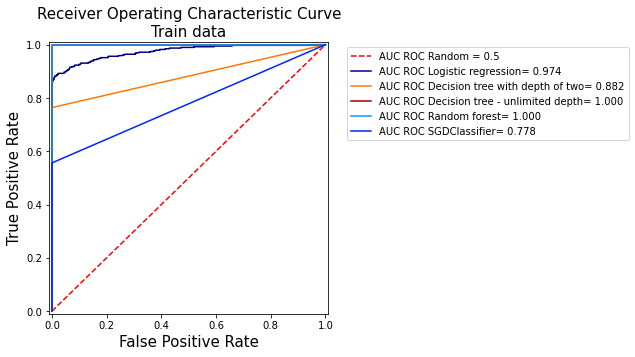

In [110]:
#Curvas roc con el conjunto de entrenamiento utilizando las predicciones hechas con dicho conjunto por cada clasificador
def get_template_roc_curve(ax, title,fs,random=True):
    
    ax.set_title(title, fontsize=fs)
    ax.set_xlim([-0.01, 1.01])
    ax.set_ylim([-0.01, 1.01])
    
    ax.set_xlabel('False Positive Rate', fontsize=fs)
    ax.set_ylabel('True Positive Rate', fontsize=fs)
    
    if random:
        ax.plot([0, 1], [0, 1],'r--',label="AUC ROC Random = 0.5")
# 2 fraudulent and 8 genuine transactions
true_labels = [1,1,0,0,0,0,0,0,0,0]d
# Probability of fraud for each transaction
fraud_probabilities = [0.5]*10
FPR_list, TPR_list, threshold = metrics.roc_curve(true_labels, fraud_probabilities, drop_intermediate=False)
ROC_AUC = metrics.auc(FPR_list, TPR_list)    
roc_curve, ax = plt.subplots(1, 1, figsize=(5,5))
cmap = plt.get_cmap('jet')
colors={'Logistic regression':cmap(0), 'Decision tree with depth of two':cmap(200), 
        'Decision tree - unlimited depth':cmap(250),
        'Random forest':cmap(70), 'SGDClassifier':cmap(40)}

get_template_roc_curve(ax,title='Receiver Operating Characteristic Curve\nTrain data',fs=15)
    
for classifier_name in classifiers_dictionary:
    
    model_and_predictions=fitted_models_and_predictions_dictionary[classifier_name]

    FPR_list, TPR_list, threshold = metrics.roc_curve(y_train, model_and_predictions['predictions_train'])
    ROC_AUC = metrics.auc(FPR_list, TPR_list)

    ax.plot(FPR_list, TPR_list, 'b', color=colors[classifier_name], label = 'AUC ROC {0}= {1:0.3f}'.format(classifier_name,ROC_AUC))
    ax.legend(loc = 'upper left',bbox_to_anchor=(1.05, 1))

Del gráfico de curva ROC para el conjunto de entrenamiento tenemos que el clasificador logístico,Random forest y arbol de decisión con profundidad ilimitada,son los que presentan valores muy similares en cuanto a rendimiento y también los más altos; notemos que de todos los 5 clasificadores el que tuvo el rendimiento más bajo sigue siendo el de gradiente descendente.


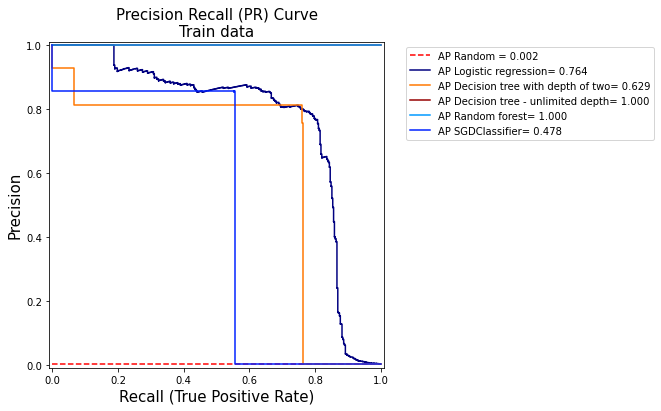

In [111]:
##Curvas de recuperabilidad vs precision con el conjunto de entrenamiento utilizando las predicciones hechas con dicho conjunto por cada clasificador
def get_template_pr_curve(ax, title,fs, baseline=0.5):
    ax.set_title(title, fontsize=fs)
    ax.set_xlim([-0.01, 1.01])
    ax.set_ylim([-0.01, 1.01])
    
    ax.set_xlabel('Recall (True Positive Rate)', fontsize=fs)
    ax.set_ylabel('Precision', fontsize=fs)
    
    ax.plot([0, 1], [baseline, baseline],'r--',label='AP Random = {0:0.3f}'.format(baseline))
pr_curve, ax = plt.subplots(1, 1, figsize=(6,6))
cmap = plt.get_cmap('jet')
colors={'Logistic regression':cmap(0), 'Decision tree with depth of two':cmap(200), 
        'Decision tree - unlimited depth':cmap(250),
        'Random forest':cmap(70), 'SGDClassifier':cmap(40)}

get_template_pr_curve(ax, "Precision Recall (PR) Curve\nTrain data",fs=15,baseline=sum(y_test)/len(y_test))
    
for classifier_name in classifiers_dictionary:
    
    model_and_predictions=fitted_models_and_predictions_dictionary[classifier_name]

    precision, recall, threshold = metrics.precision_recall_curve(y_train, model_and_predictions['predictions_train'])
    precision=precision[::-1]
    recall=recall[::-1]
    
    AP = metrics.average_precision_score(y_train, model_and_predictions['predictions_train'])
    
    ax.step(recall, precision, 'b', color=colors[classifier_name], label = 'AP {0}= {1:0.3f}'.format(classifier_name,AP))
    ax.legend(loc = 'upper left',bbox_to_anchor=(1.05, 1))
    
    
plt.subplots_adjust(wspace=0.5, hspace=0.8)

Del gráfico de precision vs recuperabilidad, tenemos que los clasificadores Random forest y árbol de decisión con profundidad ilimitada,tuvieron mejor rendimiento con respecto a los otros tres clasificadores, y el clasificador SGD sigue siendo el que tiene el peor rendimiento.

Text(0, 0.5, 'Execution times (s)')

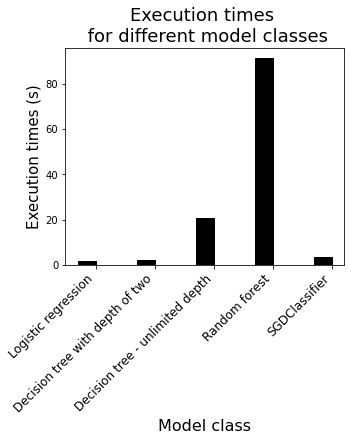

In [113]:
#Grafico de tiempo de entrenamiento para cada clasificador.
x=df_execution_times.index
y=df_execution_times['Training execution time']
fig_model_selection_execution_times_for_each_model_class, ax = plt.subplots(1, 1, figsize=(5,4))

model_classes=x
    
# width of the bars
barWidth = 0.3
# The x position of bars
r1 = np.arange(len(model_classes))
    
# Create execution times bars
ax.bar(r1, y, 
        width = barWidth, color = 'black', edgecolor = 'black', 
        capsize=7)

ax.set_xticks(r1+barWidth/2)
ax.set_xticklabels(model_classes, rotation = 45, ha="right", fontsize=12)
ax.set_title('Execution times \n for different model classes', fontsize=18)
ax.set_xlabel("Model class", fontsize=16)
ax.set_ylabel("Execution times (s)", fontsize=15)

Del gráfico de tiempos de ejecución para entrenar cada clasificador, los que obtuvieron mejores rendimientos fueron el clasificador de regresión logístico, el arbol de decisión con profundidad dos y el clasificador del gradiente descendente; este gráfico tambien nos dice que seleccionar modelos más complejos como Random forest requiere de más recursos computacionales, esto tal vez se deba a la cantidad de hiperparámetros que requiere este modelo. 

**Conclusión**: Dado que en este caso la cantidad de fraudes es muy baja, entonces estamos con un dataset imbalanceado (muchos negativos y pocos positivos), por lo que un gráfico como curvas ROC no sirve de mucho, ya que el interés en este problema es mantener la cantidad de falsos positivos lo más bajo posible, y el gráfico de curvas ROC evalua sobre todo el posible rango de FPR; así las cosas el segundo gráfico que es el de precisión vs recuperabilidad nos puede brindar información más acertada sobre cual clasificador se desempeña mejor, ya que este gráfico nos da evidencia de clasificadores que pueden tener una alta recuperación y una alta precisión (lo que indirectamente se traduce en un TPR(porcentaje de verdaderos positivos) alto y un FPR( porcentaje de falsos positivos) bajo). Para este problema entonces los clasificadores ideales serian Random forest y árbol de decisión con profundidad ilimitada, pero dado que estos dos clasificadores computacionalmente son los que más recursos requieren, entonces se puede utilizar el clasificador de regresión logística y identificar un umbral en el que su precisión mejore.

Tomemos entonces el clasificador de regresión logística y identifiquemos un umbral en el que su precisión sea del 95%, asi el calsificador tendra una precisión del 95% detectando fraudes.

In [130]:
y_scoreslogistic=fitted_models_and_predictions_dictionary['Logistic regression']['predictions_train']
precisionslogistic, recallslogistic, thresholdslogistic = metrics.precision_recall_curve(y_train, y_scoreslogistic)

In [131]:
#Umbral para obtener una precisión del 95%
threshold_95_precision = thresholdslogistic[np.argmax(precisionslogistic == 0.95)]
threshold_95_precision

3.45568034206296e-08

Asi las cosas para obtener una precisión del 95% con el clasificador de regresión logística, a la hora de determinar si una transacción es fraudulenta o no, se debe usar un umbral cercano a t=3.45568034206296e-08